# K-Means Clustering: Anime Recommendation

# Introduction

This project is about building anime recommendation based on K-Means Clustering. This method will group the data with similar characteristics into the same group. It can be applied in this project by grouping users into different clusters based on the ratings they gave to each anime. Recommended animes for each users are top-rated animes within the cluster that user belongs to and they have not been watched by a particular user. In order to find optimal k clusters, I used both Elbow Method and Silhouette Scores.

The datasets used in this project is Anime Recommendation Database 2020 from Kaggle. I downloaded only anime dataset and rating dataset. The data is retrieved from users registered in MyAnimeList.net. I dropped some columns that will not be used in this project. Before executing the K-Means clustering algorithm, the two datasets are combined. There are 12,406 animes and 310,059 users.

In this project, I devided it into 3 main parts. First, I will visualize and explore more datails from both of the datasets. Second, I will use k-means clustering for animes in Comedy, Action, and Shounen genres. Third, the main result, I will use k-means clustering with top 500 animes which are TV series, OVA, and movie.

# Download libraries

In [75]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import silhouette_score

# Download datasets: details of animes, ratings of each animes

In [2]:
anime = pd.read_csv("anime.csv")
ratings = pd.read_csv("rating_complete.csv")

In [3]:
anime.head()

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",Unknown,...,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,トライガン,TV,26,"Apr 1, 1998 to Sep 30, 1998",Spring 1998,...,50229.0,75651.0,86142.0,49432.0,15376.0,5838.0,1965.0,664.0,316.0,533.0
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),TV,26,"Jul 2, 2002 to Dec 24, 2002",Summer 2002,...,2182.0,4806.0,10128.0,11618.0,5709.0,2920.0,1083.0,353.0,164.0,131.0
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",Beet the Vandel Buster,冒険王ビィト,TV,52,"Sep 30, 2004 to Sep 29, 2005",Fall 2004,...,312.0,529.0,1242.0,1713.0,1068.0,634.0,265.0,83.0,50.0,27.0


I find all column names in anime dataset and drop some of them. I also drop rows that contain string 'Unknown'.

In [4]:
print(anime.columns)

Index(['MAL_ID', 'Name', 'Score', 'Genres', 'English name', 'Japanese name',
       'Type', 'Episodes', 'Aired', 'Premiered', 'Producers', 'Licensors',
       'Studios', 'Source', 'Duration', 'Rating', 'Ranked', 'Popularity',
       'Members', 'Favorites', 'Watching', 'Completed', 'On-Hold', 'Dropped',
       'Plan to Watch', 'Score-10', 'Score-9', 'Score-8', 'Score-7', 'Score-6',
       'Score-5', 'Score-4', 'Score-3', 'Score-2', 'Score-1'],
      dtype='object')


In [3]:
#Drop some columns from anime dataset
anime = anime.drop(['English name', 'Japanese name','Aired', 'Premiered','Popularity', 'Producers', 'Licensors', 'Duration', 'Rating', 'Studios', 
                    'Source', 'Episodes', 'Ranked', 'Members', 'Favorites', 'Watching', 'Completed', 'On-Hold', 'Dropped',
                    'Plan to Watch', 'Score-10', 'Score-9', 'Score-8', 'Score-7', 'Score-6', 'Score-5', 'Score-4', 'Score-3', 'Score-2', 'Score-1'], axis=1)

In [4]:
#Drop rows that contain string 'Unknown'
#First, find the rows containing 'Unknown' values
contain_unknowns = anime.isin(['Unknown']).any(axis=1)

#Second, drop the rows containing 'Unknown' values
anime = anime.drop(index=anime[contain_unknowns].index)

In [7]:
anime.head()

,MAL_ID,Name,Score,Genres,Type
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",TV
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Movie
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",TV
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",TV
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",TV


In [8]:
anime.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12406 entries, 0 to 17552
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   MAL_ID  12406 non-null  int64 
 1   Name    12406 non-null  object
 2   Score   12406 non-null  object
 3   Genres  12406 non-null  object
 4   Type    12406 non-null  object
dtypes: int64(1), object(4)
memory usage: 581.5+ KB


In [9]:
#Find out how many animes in anime dataset
count_anime = anime['MAL_ID'].nunique()
print(count_anime)

12406


In [10]:
ratings.head()

,user_id,anime_id,rating
0,0,430,9
1,0,1004,5
2,0,3010,7
3,0,570,7
4,0,2762,9


In [12]:
#Find out how many animes in ratings dataset
count_user = ratings['user_id'].nunique()
print(count_user)

310059


# Part I: Visualize Datasets

# Visualize Anime Dataset

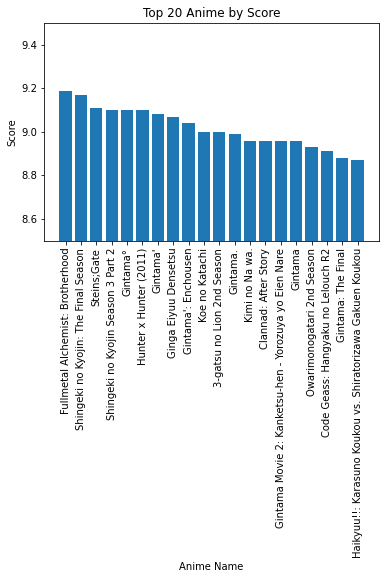

In [18]:
'''Create bar chart for top 20 animes based on score'''

# Convert Score to numerical values and sort the values to find top 20 animes
anime.loc[:, 'Score'] = pd.to_numeric(anime['Score'])
sort_anime = anime.sort_values(by='Score', ascending=False)
top_20_anime = sort_anime.head(20)

# Create the bar chart
plt.bar(top_20_anime['Name'], top_20_anime['Score'])
plt.title('Top 20 Anime by Score')
plt.xlabel('Anime Name')
plt.ylabel('Score')
plt.xticks(rotation='vertical')
plt.ylim(8.5, 9.5)
plt.show()

All of the top 20 animes are scored over 8.8 on average. Roughly, those 20 animes are scored between 8.9 to 9.2. The top 3 animes are Fullmetal Alchemist: Brotherhood, Shingeki no Kyojin: The Final Season or Attack on Titan, and Steins; Gate.

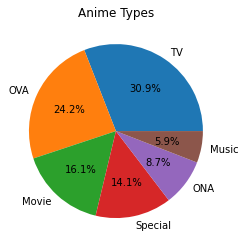

In [21]:
'''Create pie chart to find out more about each type of anime'''

#Create the pie chart
count_types = anime['Type'].value_counts()
plt.title('Anime Types')
plt.pie(count_types, labels=count_types.index, autopct='%1.1f%%')
plt.show()

From the dataset, about 31% of animes are aired on TV, 24% is OVA or Original Video Animation which is anime series that is not aired on TV, and 16% are animes shown in cinemas. The majority of the animes in this dataset are the combination of these 3 types (over 60%).

Next, I will find how many genres are there in anime dataset. I adjust the code from the lab as the dataset is splitted by ','. There are 43 genres in the dataset.

In [26]:
all_genres = []  # Create an empty list to store all genres

# Loop through each row of the dataset
for index, row in anime.iterrows():
    # Split the genres string into a list of individual genres
    genres = row['Genres'].split(',')
    # Loop through each genre in the list
    for genre in genres:
        # Add the genre to the list of all genres if it's not already there
        if genre.strip() not in all_genres:
            all_genres.append(genre.strip())
            print(genre.strip())

# Count the number of unique genres in the list
num_genres = len(all_genres)

# Print the result
print(f"There are {num_genres} genres in the dataset.")


Action
Adventure
Comedy
Drama
Sci-Fi
Space
Mystery
Shounen
Police
Supernatural
Magic
Fantasy
Sports
Josei
Romance
Slice of Life
Cars
Seinen
Horror
Psychological
Thriller
Super Power
Martial Arts
School
Ecchi
Vampire
Military
Historical
Dementia
Mecha
Demons
Samurai
Game
Shoujo
Harem
Music
Shoujo Ai
Shounen Ai
Kids
Hentai
Parody
Yuri
Yaoi
There are 43 genres in the dataset.


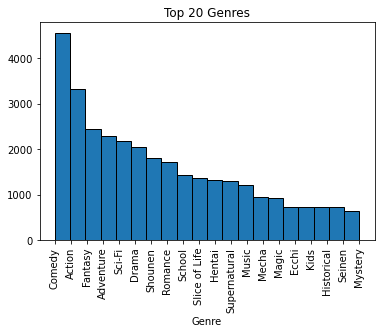

In [24]:
'''Create histogram to show popular genres in the dataset'''

# Split the genres into separate columns using str.split()
genre_cols = anime['Genres'].str.split(',', expand=True)

# Apply str.strip() to remove any leading/trailing whitespace from genre names
genre_cols = genre_cols.apply(lambda x: x.str.strip())

# Combine the genre columns using Series.str.cat() and store the result in a new column
anime['Split Genres'] = genre_cols.apply(lambda x: x.str.cat(sep=', '), axis=1)

# Use value_counts() to count the occurrences of each genre
genre_counts = genre_cols.stack().value_counts()

# Get the top 20 genres
top_20_genres = genre_counts.head(20)

# Create a histogram of the top 20 genres
plt.hist(x=top_20_genres.index, weights=top_20_genres, bins=20, edgecolor='black')
plt.title('Top 20 Genres')
plt.xlabel('Genre')
plt.xticks(rotation=90)
plt.show()


Each anime can have more than one genre. From the histogram, about 4500 animes are comedy and about 3250 animes are categorized as action. These 2 genres are the most common anime genres.

# Visualize Ratings Dataset

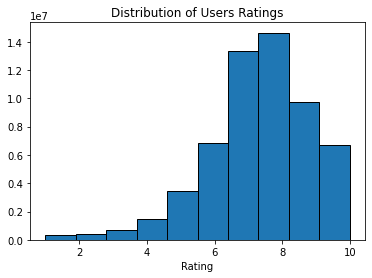

In [23]:
'''Create histogram for users ratings'''

plt.hist(ratings['rating'], bins=10, edgecolor='black')
plt.title('Distribution of Users Ratings')
plt.xlabel('Rating')
plt.show()

From here, the number of animes in anime dataset is higher than the number of animes in ratings dataset because ratings datasets contains only users who complete watching the all episodes of anime. In addition, user can rate the anime from 1 to 10 and there are 186 ratings per user.

In [27]:
print('There is an average of', round(len(ratings)/len(ratings["user_id"].unique())), 'ratings per user.')

There is an average of 186 ratings per user.


In [28]:
print('Users can rate animes as:',sorted(ratings["rating"].unique()))

Users can rate animes as: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


# Merge 2 Data Sets

From here, I change the column name in anime data set so that it can be merged with rating data set.

In [5]:
#Change column name to merge datasets
anime = anime.rename(columns={'MAL_ID':'anime_id'})

In [6]:
#Merge two datasets on 'anime_id'
df = pd.merge(anime, ratings, on='anime_id')

In [10]:
df.head()

,anime_id,Name,Score,Genres,Type,user_id,rating
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",TV,3,9
1,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",TV,6,6
2,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",TV,14,9
3,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",TV,19,8
4,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",TV,22,9


In [21]:
#Check if rating contains NAs
df['rating'].isna().any()

False

As the dataset is very large now, I will choose the popular types of anime including TV series, Movie, and OVA. The code below is to create new dataframe after filtering out other types of anime.

In [7]:
df = df[(df['Type']=='TV') | (df['Type']=='Movie') | (df['Type']=='OVA')]

In [8]:
df.head()

,anime_id,Name,Score,Genres,Type,user_id,rating
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",TV,3,9
1,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",TV,6,6
2,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",TV,14,9
3,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",TV,19,8
4,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",TV,22,9


# Part II: Comedy, Action, and Shounen Animes

In this part, I will find average ratings of Comedy and Shounen animes by each user_id. These genres are my favorites. First, define function with inputs including dataframe, chosen genres, and the column names of new dataframe. Note that shounen is anime genre refers to the target group of boys under 15 years old.

In [9]:
#All 'Genres' values in this data contains genres, so I adjusted the code from the lab
def get_user_genre_ratings(df, genres, colnames):
    user_genre_ratings = pd.DataFrame()
    for genre in genres:
        genre_df = df[df['Genres'].str.contains(genre)] #subset dataframe by genres
        genre_user_avg_ratings = genre_df.groupby(['user_id'])['rating'].mean().round(2)
        user_genre_ratings = pd.concat([user_genre_ratings, genre_user_avg_ratings], axis=1)
    user_genre_ratings.columns = colnames
    return user_genre_ratings

Second, create new dataframe for average rating of the three genres by each user id.

In [10]:
Comedy_Action_Shounen = get_user_genre_ratings(df, ['Comedy', 'Action', 'Shounen'], ['Comedy_avg_rating', 'Action_avg_rating', 'Shounen_avg_rating'])

In [11]:
Comedy_Action_Shounen.head()

,Comedy_avg_rating,Action_avg_rating,Shounen_avg_rating
0,7.87,7.89,7.17
1,7.86,7.89,8.13
2,8.50,8.55,8.61
3,7.49,7.57,7.65
4,7.72,7.53,7.55


In [18]:
#Check if there are some missing values
Comedy_Action_Shounen.isna().any()

Comedy_avg_rating     True
Action_avg_rating     True
Shounen_avg_rating    True
dtype: bool

There are some NAs as some users may not rate anime with either genres. I will replace the missing values with the lowest rating 1.

In [12]:
Comedy_Action_Shounen.fillna(1, inplace=True)

# Apply Elbow Method for Optimal Number of Clusters

The dataset is large so that it takes longer time to get the result using silhouette score to determine optimal number of k. Accordingly, I will use the Elbow Method to find optimal k instead. In order to plot the Elbow graph, I need to find sumsquare errors (sse) in each number of k. The sse measures how far the data point is from the center of the cluster; hence, it is better to get lower sse. 

In [20]:
#Find sse for each cluster
sse = [] #Create empty list for sse
for k in range(1,16): #I try with 10 clusters
    km = KMeans(n_clusters=k)
    km.fit(Comedy_Action_Shounen)
    sse.append(km.inertia_) #add sse for each cluster into a list

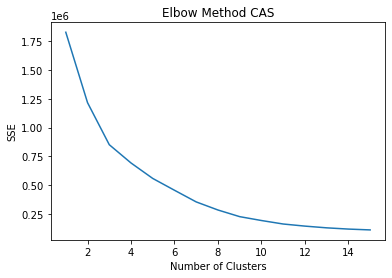

In [21]:
#Plot sse to find out the optimal number of clusters
plt.plot(range(1,16), sse)
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.title('Elbow Method CAS')
plt.show()

From the graph above, we will look for the kink in the graph that will be followed by a smooth and slow drop of sse. There are 2 potential of optimal k clusters (4 and 9). I will choose 9 clusters as the sse after 9 clusters are decreasing at slower rate.

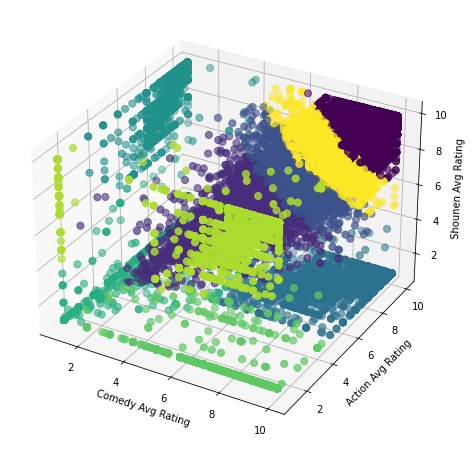

In [22]:
# Run 9 means clustering on the filtered dataset
kmeans = KMeans(n_clusters=9, random_state=511).fit(Comedy_Action_Shounen)

# Add a 'Cluster' column to the DataFrame indicating which cluster each data point belongs to
Comedy_Action_Shounen['Cluster'] = kmeans.labels_

# Plot the data points with color-coding based on the 'Cluster' column
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(Comedy_Action_Shounen['Comedy_avg_rating'], 
                      Comedy_Action_Shounen['Action_avg_rating'], 
                      Comedy_Action_Shounen['Shounen_avg_rating'], 
                      c=Comedy_Action_Shounen['Cluster'], 
                      cmap='viridis', 
                      s=50)

ax.set_xlabel('Comedy Avg Rating')
ax.set_ylabel('Action Avg Rating')
ax.set_zlabel('Shounen Avg Rating')

plt.show()

I created scatter plot for 9 clusters. The data may have many missing values because there are many 1 ratings. The data does not spread equally as the users may rate anime in these genres in the same way.

# Part III: Anime Recommendation

# Create User Ratings Dataset

In [14]:
#Drop more columns from df dataset
recommender = df.drop(['anime_id', 'Score', 'Genres', 'Type'], axis=1)

In [15]:
recommender.head()

,Name,user_id,rating
0,Cowboy Bebop,3,9
1,Cowboy Bebop,6,6
2,Cowboy Bebop,14,9
3,Cowboy Bebop,19,8
4,Cowboy Bebop,22,9


In [16]:
# Get average rating for each anime by user_id. I use 'groupby' and 'unstack()' instead of pivot table because it takes shorter time to run
grouped_data = recommender.groupby(['user_id', 'Name'])['rating'].mean()

In [17]:
# Create pivot table
user_ratings = grouped_data.unstack()

/Users/suwitchayakeepthong/opt/anaconda3/lib/python3.9/site-packages/pandas/core/reshape/reshape.py:134: PerformanceWarning: The following operation may generate 2710035560 cells in the resulting pandas object.
  warnings.warn(


In [18]:
user_ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 309860 entries, 0 to 353404
Columns: 8746 entries, "Bungaku Shoujo" Kyou no Oyatsu: Hatsukoi to ēlDLIVE
dtypes: float64(8746)
memory usage: 20.2 GB


In [19]:
user_ratings.head()

Name,"""Bungaku Shoujo"" Kyou no Oyatsu: Hatsukoi","""Bungaku Shoujo"" Memoire","""Bungaku Shoujo"" Movie","""Eiji""","""Eiyuu"" Kaitai","""Parade"" de Satie","""Tokyo""",** Kouhai,.hack//G.U. Returner,.hack//G.U. Trilogy,...,number24,s.CRY.ed,s.CRY.ed Alteration I: Tao,s.CRY.ed Alteration II: Quan,xxxHOLiC,xxxHOLiC Kei,xxxHOLiC Movie: Manatsu no Yoru no Yume,xxxHOLiC Rou,xxxHOLiC Shunmuki,ēlDLIVE
user_id,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,8.0,9.0,NaN,NaN,8.0,NaN


# Heatmap for top 30 Animes

In this part, I will create heatmap for the top 30 anime for 30 users that are randomly chosen from the sample to findout more about the data.

In [20]:
#Create a list for top 30 most rated animes
most_rated_30 = user_ratings.count().sort_values(ascending=False)[:30].index.tolist()

In [21]:
#Filter dataframe
top_30_animes = user_ratings[most_rated_30]

In [22]:
#Filter data frame to maintain only users who rated at least 24 animes or 80 percent
filtered_df = top_30_animes.dropna(thresh=24)

In [23]:
#Randomly pick 30 rows from the dataframe
most_rated_30 = filtered_df.sample(n=30, random_state=511)

In [24]:
most_rated_30

Name,Death Note,Shingeki no Kyojin,Sword Art Online,Angel Beats!,One Punch Man,Code Geass: Hangyaku no Lelouch,Toradora!,Fullmetal Alchemist: Brotherhood,No Game No Life,Tokyo Ghoul,...,Another,Ao no Exorcist,Boku dake ga Inai Machi,Ano Hi Mita Hana no Namae wo Bokutachi wa Mada Shiranai.,Clannad,Re:Zero kara Hajimeru Isekai Seikatsu,Sword Art Online II,Shingeki no Kyojin Season 2,Koe no Katachi,Boku no Hero Academia 2nd Season
user_id,,,,,,,,,,,,,,,,,,,,,
42698,9.0,9.0,NaN,10.0,9.0,9.0,10.0,10.0,9.0,NaN,...,8.0,NaN,9.0,9.0,9.0,10.0,NaN,8.0,9.0,9.0
90613,9.0,8.0,4.0,8.0,6.0,8.0,10.0,10.0,5.0,5.0,...,8.0,7.0,8.0,9.0,10.0,6.0,5.0,8.0,8.0,NaN
5102,9.0,8.0,8.0,9.0,9.0,NaN,6.0,10.0,7.0,9.0,...,8.0,6.0,7.0,NaN,8.0,9.0,8.0,9.0,NaN,9.0
7089,7.0,7.0,8.0,8.0,9.0,8.0,7.0,8.0,8.0,6.0,...,NaN,6.0,5.0,8.0,7.0,7.0,8.0,7.0,NaN,7.0
314924,10.0,9.0,8.0,7.0,10.0,8.0,9.0,NaN,7.0,7.0,...,NaN,NaN,9.0,8.0,8.0,8.0,7.0,10.0,9.0,8.0
212197,8.0,10.0,4.0,8.0,8.0,9.0,7.0,10.0,4.0,3.0,...,1.0,4.0,7.0,6.0,3.0,9.0,4.0,10.0,8.0,7.0
256931,10.0,9.0,10.0,9.0,8.0,10.0,7.0,10.0,9.0,8.0,...,8.0,9.0,10.0,9.0,10.0,9.0,7.0,9.0,9.0,NaN
85444,9.0,10.0,8.0,10.0,10.0,10.0,6.0,10.0,9.0,NaN,...,9.0,8.0,10.0,10.0,8.0,9.0,8.0,10.0,10.0,10.0
278115,NaN,7.0,10.0,9.0,9.0,10.0,9.0,10.0,7.0,8.0,...,10.0,8.0,10.0,10.0,NaN,9.0,9.0,8.0,8.0,NaN


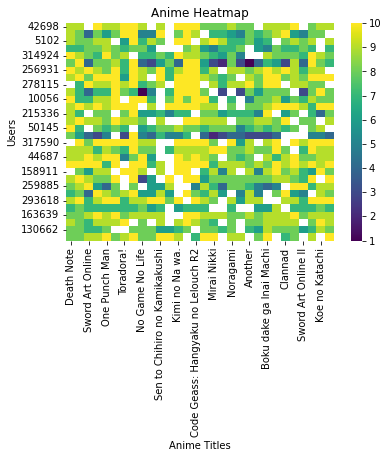

In [76]:
#Create heatmap
heatmap = sns.heatmap(most_rated_30, cmap='viridis', vmin=1, vmax=10)

#Plot title and axis labels
heatmap.set_title('Anime Heatmap')
heatmap.set_xlabel('Anime Titles')
heatmap.set_ylabel('Users')

# Show plot
plt.show()

From the heatmap, none of the users rated all 30 animes. Some users may give most of the animes at very low ratings (such as 171823), while some users may give most of animes at very high ratings (such as 317590). In addition, Fullmetal Alchemist and Code Geass are rated 10 by many users in the sample.

# Recommender System for Each User

I will choose recommender for top 500 animes

In [34]:
#Create a list for top 500 most rated animes
most_rated_500 = user_ratings.count().sort_values(ascending=False)[:500].index.tolist()

In [35]:
#Filter dataframe
top_500_animes = user_ratings[most_rated_500]

In [36]:
#There are some users who barely rated animes, I will drop users who rated less than 100 animes
filtered_df = top_500_animes.dropna(thresh=50)

In [37]:
#Get median for each anime
median_ratings = filtered_df.median()

In [38]:
#Fill NAs with median of the ratings
imputed_data = filtered_df.fillna(median_ratings)

In [39]:
print(imputed_data.shape)

(178158, 500)


There are 178158 users and 500 animes in this dataset.

#  Apply Elbow Method for Optimal Number of Clusters

In [40]:
#Find sse for each cluster
sse = [] #Create empty list for sse
for k in range(1,16): #I try with 10 clusters
    km = KMeans(n_clusters=k)
    km.fit(imputed_data)
    sse.append(km.inertia_) #add sse for each cluster into a list

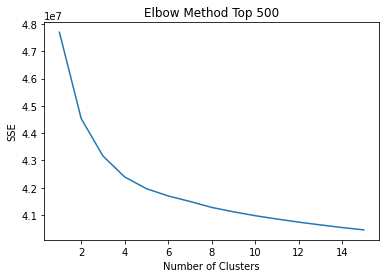

In [41]:
#Plot sse to find out the optimal number of clusters
plt.plot(range(1,16), sse)
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.title('Elbow Method Top 500')
plt.show()

According to the Elbow Method, it is not clear to see the optimal k for k-means clustering. I will proceed silhouette scores starting from k=4 because the sse started to drop smoothly after that point.

# Calculate Silhouette Scores for k in range (4, 21)

The silhouette scores are calculated to find optimal k. The range of the score ranges between 1 and -1. The higher silhouette score refers to more appropriate number of cluster. I devided the range of k into different code blocks to reduce the run time.

In [46]:
for k in range(4, 8):
    kmeans = KMeans(n_clusters=k, random_state=511)
    labels = kmeans.fit(imputed_data)
    score = silhouette_score(imputed_data, labels.labels_.ravel())
    print(f"For k={k}, the silhouette score is {score}")

For k=4, the silhouette score is 0.07091705808955338
For k=5, the silhouette score is -0.005685789444341408
For k=6, the silhouette score is -0.002725715852383771
For k=7, the silhouette score is -0.0005977559904771129


In [47]:
for k in range(8, 15):
    kmeans = KMeans(n_clusters=k, random_state=511)
    labels = kmeans.fit(imputed_data)
    score = silhouette_score(imputed_data, labels.labels_.ravel())
    print(f"For k={k}, the silhouette score is {score}")

For k=8, the silhouette score is -0.0005691969725123857
For k=9, the silhouette score is -0.019201243558859507
For k=10, the silhouette score is -0.03011887470671046
For k=11, the silhouette score is -0.02789450089422653
For k=12, the silhouette score is -0.016754758421599042
For k=13, the silhouette score is -0.02101653000258471
For k=14, the silhouette score is -0.031164893415901104


In [48]:
for k in range(15, 21):
    kmeans = KMeans(n_clusters=k, random_state=511)
    labels = kmeans.fit(imputed_data)
    score = silhouette_score(imputed_data, labels.labels_.ravel())
    print(f"For k={k}, the silhouette score is {score}")

For k=15, the silhouette score is -0.03155104399215146
For k=16, the silhouette score is -0.03513217553710999
For k=17, the silhouette score is -0.0380302251079722
For k=18, the silhouette score is -0.038096234675812454
For k=19, the silhouette score is -0.03536879221758016
For k=20, the silhouette score is -0.038413123852275105


We see that k=4 has highest silhouette score. However, the dataset is very large so that I will choose k=12 as it has comparatively low silhouette score and allow me to devide the data into more clusters.

# Execute K-means Clustering

In [49]:
#Run KMeans algorithm on imputed data for k=12
kmeans_top_500 = KMeans(n_clusters=12, random_state=511).fit(imputed_data)

In [50]:
#Get cluster label for each row
predictions = kmeans_top_500.predict(imputed_data)

In [51]:
#Reset index for the dataset
clustered_data = filtered_df.reset_index()

In [52]:
#Create new column for cluster of each user_id
clustered_data["cluster"] = predictions

In [53]:
clustered_data.head()

Name,user_id,Death Note,Shingeki no Kyojin,Sword Art Online,Angel Beats!,One Punch Man,Code Geass: Hangyaku no Lelouch,Toradora!,Fullmetal Alchemist: Brotherhood,No Game No Life,...,Non Non Biyori,Oda Nobuna no Yabou,Machine-Doll wa Kizutsukanai,Shinchou Yuusha: Kono Yuusha ga Ore Tueee Kuse ni Shinchou Sugiru,Domestic na Kanojo,Tsuki ga Kirei,Haikyuu!!: To the Top,Free!: Eternal Summer,Fate/stay night Movie: Unlimited Blade Works,cluster
0,1,9.0,10.0,5.0,6.0,8.0,10.0,9.0,10.0,8.0,...,NaN,NaN,NaN,NaN,NaN,NaN,8.0,NaN,NaN,8
1,3,NaN,NaN,NaN,8.0,8.0,8.0,8.0,NaN,8.0,...,NaN,NaN,NaN,NaN,7.0,NaN,NaN,NaN,NaN,4
2,6,7.0,NaN,NaN,10.0,NaN,8.0,NaN,10.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,4
3,7,NaN,8.0,8.0,9.0,NaN,NaN,8.0,10.0,8.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
4,11,10.0,10.0,8.0,9.0,NaN,10.0,10.0,10.0,10.0,...,NaN,NaN,10.0,NaN,NaN,NaN,NaN,9.0,NaN,11


In [54]:
# Create function that will return the recommended animes and their average ratings to each user

def recommend_anime_for_user(userid, num_recommendations, clustered_data):
    
    #Get cluster number of the user by adding value of cluster column to the list
    cluster_number = clustered_data.loc[clustered_data['user_id']==userid].cluster.tolist()[0]
    
    #Sort the cluster by highest rated movie
    anime_dict = {}
    for i, rating in enumerate(kmeans_top_500.cluster_centers_[cluster_number]):
        anime_dict.update({clustered_data.columns[1:-1].tolist()[i] : rating})
    sorted_animes = dict(sorted(anime_dict.items(), key=lambda x: x[1], reverse=True)) #Sort anime in dict in descending order
    
    #Create loop to go through anime names that are have not watched by the user
    recommended_animes = {}
    for i, name in enumerate(sorted_animes):
        if len(recommended_animes) == num_recommendations: #Stop the loop when we have required amount of recommendations in the function
            break
    
        # Get the rating the user gave the movie
        rating = clustered_data[str(name)].loc[clustered_data["user_id"]==userid].tolist()[0]
        
        # If the user didn't rate the movie then add it to the recommended movies list
        if math.isnan(rating) == True:   
            # Get the cluster avg. rating
            rating_cluster_avg = sorted_animes.get(str(name))
            # Add title and avg. rating to dictionary
            recommended_animes[str(name)] = rating_cluster_avg
    
    return cluster_number, recommended_animes


Now, I will find out which user id is in the dataset.

In [73]:
# Test if the function works fine
recommend_anime_for_user(36, 5, clustered_data)

(4,
 {'Fullmetal Alchemist: Brotherhood': 9.6990159901599,
  'Kimi no Na wa.': 9.13328061852047,
  'Clannad: After Story': 9.099138991389923,
  'Hunter x Hunter (2011)': 9.095853101388158,
  'Koe no Katachi': 9.058917589175895})

In [74]:
id = 36
cluster, recommended_animes = recommend_anime_for_user(36, 5, clustered_data)

print('The user id ', id, 'is in cluster number', cluster, '.')
print('The recommended animes for this user are: ', recommended_animes )

The user id  36 is in cluster number 4 .
The recommended animes for this user are:  {'Fullmetal Alchemist: Brotherhood': 9.6990159901599, 'Kimi no Na wa.': 9.13328061852047, 'Clannad: After Story': 9.099138991389923, 'Hunter x Hunter (2011)': 9.095853101388158, 'Koe no Katachi': 9.058917589175895}


# Conclusion

The 12-means clustering is executed to the top 500 animes. I created the function that will return the recommended animes and their average ratings to each user. The recommended animes are the top rated animes within the cluster that the user belongs to and they have not been watched by the user. The function works fine and successfully show the result. For example, the user 36 belongs to cluster 4 and the 5 recommended animes are Full metal Alchemist: Brotherhood, Kimi no Na wa (Your Name), Clannad: After Story, Hunter x Hunter (2011), and Koe no Katachi (A Silent Voice).

For Part III, there is a challenging question that requires further exploration. I tried to use k-means clustering to recommend animes for each user. The optimal number of k is determined by using Elbow Method and Silhouette Scores. However, the result for optimal k is not quite clear. I chose to use k=12 to devide data into more clusters as the dataset is large compared to the 3 genres case. The Silhouette score is lower despite the increase in number of k. It can be because the data does not have clear clusters. There are some others methods instead of k-means clustering which can improve the results from recommender system; for example, matrix factorization that will help decomposing data into lower dimensional.

# Link to dataset

https://www.kaggle.com/datasets/hernan4444/anime-recommendation-database-2020?resource=download&select=anime.csv